In [43]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer # type: ignore
from tensorflow.keras.preprocessing.sequence import pad_sequences #type: ignore
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import wordcloud
import re
import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
nltk.download('punkt')

from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Ahmad\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [44]:
tokenizer = Tokenizer(num_words = 30730, oov_token="<OOV>")
#tokenizer.fit_on_texts(sentences)
#word_index = tokenizer.word_index
#print(word_index)

In [45]:
df = pd.read_csv("data/tweets.csv")
df = df.set_index("id")
df.head()

,keyword,location,text,target
id,,,,
0,ablaze,NaN,"Communal violence in Bhainsa, Telangana. ""Ston...",1
1,ablaze,NaN,Telangana: Section 144 has been imposed in Bha...,1
2,ablaze,New York City,Arsonist sets cars ablaze at dealership https:...,1
3,ablaze,"Morgantown, WV",Arsonist sets cars ablaze at dealership https:...,1
4,ablaze,NaN,"""Lord Jesus, your love brings freedom and pard...",0


<h1>balancing the data</h1>

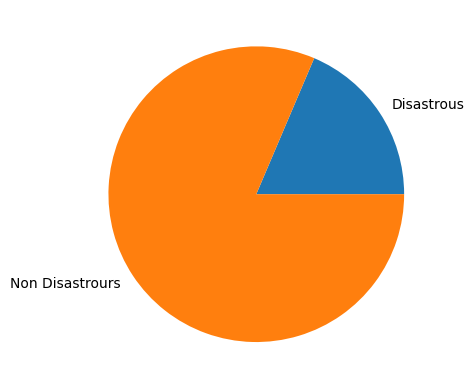

In [46]:
target = df["target"].value_counts()
plt.pie([target[1],target[0]],labels=["Disastrous","Non Disastrours"])
plt.show()

In [47]:
print(target[1])
zerorows = df[df["target"]==0]
onerows = df[df["target"]==1]
zerorows = zerorows.iloc[:2114]
new_df = pd.concat([zerorows,onerows])


2114


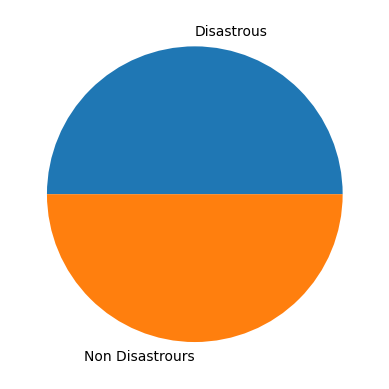

In [48]:
target = new_df["target"].value_counts()
plt.pie([target[1],target[0]],labels=["Disastrous","Non Disastrours"])
plt.show()

In [49]:
print(new_df.describe())

            target
count  4228.000000
mean      0.500000
std       0.500059
min       0.000000
25%       0.000000
50%       0.500000
75%       1.000000
max       1.000000


<h1>Removing URLs from data using regular expression</h1>

In [50]:
new_df.sort_index()


,keyword,location,text,target
id,,,,
0,ablaze,NaN,"Communal violence in Bhainsa, Telangana. ""Ston...",1
1,ablaze,NaN,Telangana: Section 144 has been imposed in Bha...,1
2,ablaze,New York City,Arsonist sets cars ablaze at dealership https:...,1
3,ablaze,"Morgantown, WV",Arsonist sets cars ablaze at dealership https:...,1
4,ablaze,NaN,"""Lord Jesus, your love brings freedom and pard...",0
...,...,...,...,...
11338,wrecked,Puchong,Kesian ular. We have wrecked their natural hab...,1
11354,wrecked,NaN,"Yeah, proper Liverpool fans wrecked Man City’s...",1
11355,wrecked,Recife,"""Trump and Sisi 'rejected foreign exploitation...",1


In [53]:
url_pattren = re.compile(r'https?://\S+|www\.\S+')
for i in range(len(new_df)):
    a = new_df["text"].iloc[i]
    b = url_pattren.findall(a)
    if not b:
        continue
    else:
        a = a.replace(b[0],"")
        new_df["text"].iloc[i] = a
    

C:\Users\Ahmad\AppData\Local\Temp\ipykernel_15192\1947969119.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df["text"].iloc[i] = a
C:\Users\Ahmad\AppData\Local\Temp\ipykernel_15192\1947969119.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df["text"].iloc[i] = a


<h1>Stemming and Tokenization</h1>

In [54]:
stemmer = PorterStemmer()

def stem_text(text):
    words = word_tokenize(text)
    stemmed_words = [stemmer.stem(word) for word in words]
    return ' '.join(stemmed_words)

new_df["text"] = new_df["text"].apply(stem_text)

print(new_df)

       keyword        location  \
id                               
4       ablaze             NaN   
5       ablaze              OC   
8       ablaze    Accra, Ghana   
9       ablaze       Searching   
11      ablaze             NaN   
...        ...             ...   
11338  wrecked         Puchong   
11354  wrecked             NaN   
11355  wrecked          Recife   
11359  wrecked  Washington, DC   
11369  wrecked             NaN   

                                                    text  target  
id                                                                
4      `` lord jesu , your love bring freedom and par...       0  
5      if thi child wa chines , thi tweet would have ...       0  
8      nation secur minist , kan dapaah 's side chic ...       0  
9      thi creatur who ’ s soul is no longer clarent ...       0  
11     social media went banana after chuba hubbard a...       0  
...                                                  ...     ...  
11338  kesian ular . 

In [65]:
new_df2 = new_df.drop(["keyword","location"],axis=1)
new_df2 = new_df2.sample(frac=1,random_state=42)

new_df2.describe()

,target
count,4228.000000
mean,0.500000
std,0.500059
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


In [66]:
training_Sentences = new_df2[["text","target"]].iloc[:3381]
testing_Sentences = new_df2[["text","target"]].iloc[3381:]


tokenizer.fit_on_texts(training_Sentences["text"])
wl = tokenizer.word_index

training_Sequences = tokenizer.texts_to_sequences(training_Sentences["text"])
testing_Sequences = tokenizer.texts_to_sequences(testing_Sentences["text"])
padded_train = pad_sequences(training_Sequences,padding="post")
padded_test = pad_sequences(testing_Sequences,padding="post")
dfcsv = pd.DataFrame(padded_train)
dfcsv.to_csv("padded.csv")

In [67]:
training_Sentences = new_df2[["text","target"]].iloc[:3381]
testing_Sentences = new_df2[["text","target"]].iloc[3381:]

vectorizer = TfidfVectorizer()
x = vectorizer.fit_transform(training_Sentences["text"])
y = vectorizer.transform(testing_Sentences["text"])

In [68]:

nbmodel = GaussianNB()

nbmodel.fit(x.toarray(),training_Sentences["target"])

y_pred = nbmodel.predict(y.toarray())

print(classification_report(testing_Sentences["target"],y_pred))

              precision    recall  f1-score   support

           0       0.80      0.65      0.72       420
           1       0.71      0.84      0.77       427

    accuracy                           0.74       847
   macro avg       0.75      0.74      0.74       847
weighted avg       0.75      0.74      0.74       847



In [ ]:
testing_Sequences = tokenizer.texts_to_sequences(testing_Sentences)
padded_test = pad_sequences(testing_Sequences)